### Importing 

In [2]:
from azure.storage.blob import BlobServiceClient, ContainerClient, BlobPrefix
import cv2
import imageio.v3 as iio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from torchviz import make_dot
from copy import deepcopy
import time

# Get the directory of the current script file
os.chdir(r'C:\Users\Ecko_\exjobb_jupyter')
#print(os.getcwd())

### Blob Storage Set-up

In [3]:
STORAGEACCOUNTURL = "https://exjobbssl1863219591.blob.core.windows.net"
STORAGEACCOUNTKEY = "PuL1QY8bQvIyGi653lr/9CPvyHLnip+cvsu62YAipDjB7onPDxfME156z5/O2NwY0PRLMTZc86/6+ASt5Vts8w=="
CONTAINERNAME = "exjobbssl"
FOLDERNAME = "UCF-101/GolfSwing/" #Temporary during the development phase
#BLOBNAME = "UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi"

blob_service_client_instance = BlobServiceClient(
    account_url=STORAGEACCOUNTURL, credential=STORAGEACCOUNTKEY)

# CALL SPECIFIC BLOB
# #blob_client_instance = blob_service_client_instance.get_blob_client(
#    CONTAINERNAME, BLOBNAME, snapshot=None)
#blob_data = blob_client_instance.download_blob()
#data = blob_data.readall()

container_client_instance = blob_service_client_instance.get_container_client(CONTAINERNAME)
#blob_list = container_client_instance.list_blobs()

### Load Videos Into Memory

In [4]:
class BlobSamples(object):
    def __init__(self):
        self.depth = 0
        self.indent = "  "

    def list_blobs_hierarchical(self, container_client: ContainerClient, prefix):
        for blob in container_client_instance.walk_blobs(name_starts_with=prefix, delimiter='/'):
            if isinstance(blob, BlobPrefix):
                # Indentation is only added to show nesting in the output
                print(f"{self.indent * self.depth}{blob.name}")
                self.depth += 1
                self.list_blobs_hierarchical(container_client_instance, prefix=blob.name)    
                self.depth -= 1
                #print('hi')
            else:
                print(f"{self.indent * self.depth}{blob.name}")

    def load_videos_into_memory(self, blob_service_client: BlobServiceClient, container_name, folder_name, videos_loaded):
        container_client = blob_service_client.get_container_client(container=container_name)

        blob_list = container_client.list_blobs(name_starts_with=folder_name)

        videos = []
        counter = 0  # Add a counter
        for blob in blob_list:
            if counter >= videos_loaded:  # Break the loop after loading 5 videos
                break
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob.name)
            video_data = blob_client.download_blob().readall()

            # Create a dictionary for the video
            video = {
                'path': blob.name,  # The path of the video
                'data': video_data  # The bytes data of the video
            }

            videos.append(video)
            counter += 1  # Increment the counter
        return videos

# LIST ALL FOLDERS – Usage of the hierarchical list_blobs function
#sample = BlobSamples()
#sample.list_blobs_hierarchical(container_client_instance, "")

# Usage:
sample = BlobSamples()

videos_loaded = 200
print('loading videos')
videos = sample.load_videos_into_memory(blob_service_client_instance, CONTAINERNAME, FOLDERNAME, videos_loaded)
print('videos loaded')
print("Amount of videos loaded: " + str(len(videos)))

loading videos
videos loaded
Amount of videos loaded: 139


### Prepare Datasets

In [5]:
class PreparedDataset(Dataset):
    def __init__(self, videos, trainval='train'):
        self.video_names_train = []
        self.video_names_test = []
        self.action_labels_train = []
        self.action_labels_test = []
        self.predata_train = []
        self.predata_test = []
        self.videos = videos
        self.trainval = trainval

        # Read the classes file
        with open('classInd.txt', 'r') as f:
            classes = f.readlines()
        classes = [c.strip().split(' ', 1)[1] for c in classes]
        self.class_to_id = {c: i for i, c in enumerate(classes)} #dictionary

        # First, read the paths and labels from the trainlist and testlist files into dictionaries
        train_paths = {}
        test_paths = {}
        with open('trainlist1.txt', 'r') as f:
            for line in f:
                path, label = line.strip().split(' ')
                train_paths[path] = int(label)-1  # Subtract 1 to make the labels 0-indexed
        with open('testlist1.txt', 'r') as f:
            test_paths = {line.strip() for line in f}
        for video in videos:
            path = video['path'][len('UCF-101/'):]  # Remove the 'UCF-101/' prefix from the video path
            video_name = path.split('/')[1].split('.avi')[0].replace('v_', '') #Extracting the name
            if path in train_paths:
                self.video_names_train.append(video_name)
                label = train_paths[path]  # Extract the label from the dictionary
                self.action_labels_train.append(label)
                self.predata_train.append(video)
            elif path in test_paths:
                self.video_names_test.append(video_name)
                class_name = path.split('/')[0]
                label = self.class_to_id[class_name]
                self.action_labels_test.append(label)
                self.predata_test.append(video)

    def __getitem__(self, index):  # https://stackoverflow.com/questions/43627405/understanding-getitem-method-in-python
        if self.trainval == 'train':
            video_name = self.video_names_train[index]
            label = self.action_labels_train[index]
            video = self.predata_train[index]
        else:
            video_name = self.video_names_test[index]
            label = self.action_labels_test[index]
            video = self.predata_test[index]
            
        # Convert the bytes to frames
        #video = iio.imread(video_bytes, index=None, format_hint=".avi")

        return video, label, video_name

    def __len__(self):
        if self.trainval == "train":
            return len(self.predata_train)
        else:
            return len(self.predata_test)

### Train/test Dataset Test

Number of training videos: 100
Number of testing videos: 39
(141, 240, 320, 3)
(173, 240, 320, 3)
(181, 240, 320, 3)
(171, 240, 320, 3)
(168, 240, 320, 3)
(269, 240, 320, 3)


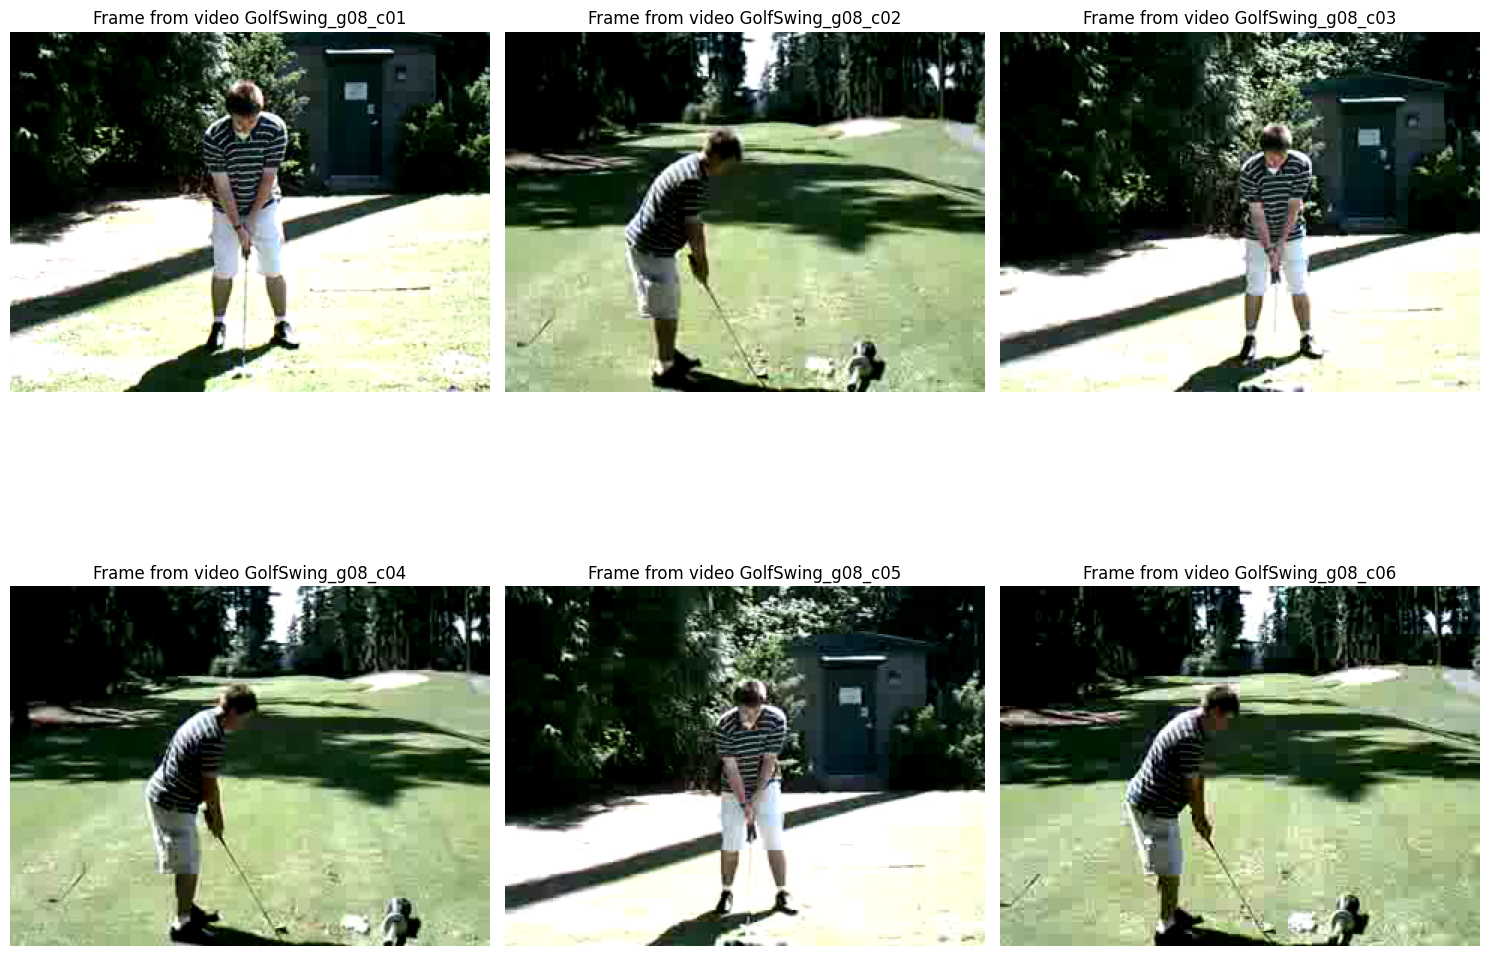

In [49]:
# Initialize the train/test dataset
video_dataset = PreparedDataset(videos, trainval='train')

# Print the first 5 file paths from filelist_train and filelist_test
def test_video_dataset(dataset, n):
    print(f"Number of training videos: {len(dataset.predata_train)}")
    print(f"Number of testing videos: {len(dataset.predata_test)}")

    #print(dataset.actionlabels_train[:15])
    #print(dataset.actionlabels_test[:15])

    #print(dataset.video_names_train[:15])
    #print(dataset.video_names_test[:15])

    fig, axs = plt.subplots(nrows=(n+2)//3, ncols=3, figsize=(15, 5*(n+2)//3))

    # Display the first n videos from the training data
    for i, video_data in enumerate(dataset.predata_train[:n]):  # Only take the first n videos from training data
        frames = iio.imread(video_data['data'], index=None, format_hint=".avi")
        print(frames.shape)
        frame = frames[0]

        # Display the frame using pyplot
        axs[i//3, i%3].imshow(frame)
        axs[i//3, i%3].set_title(f'Frame from video {dataset.video_names_train[i]}')
        axs[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_display = 6
test_video_dataset(video_dataset, amount_of_videos_to_display)

### Image Re-ordering & Preprocessing

In [191]:
class PreprocessedTemporalFourData(Dataset):
    def __init__(self, dataset, trainval='train', mean=[96.5, 96.5, 96.5], patch_size=120):
        self.dataset = dataset
        self.trainval = trainval
        self.mean = mean
        self.patch_size = patch_size
        self.counter = 0 
        
    def __len__(self):
        if self.trainval == 'train':
            return len(self.dataset.predata_train)
        else:
            return len(self.dataset.predata_test)

    def __getitem__(self, index):
        video, action_label, video_name = self.get_video_data(index)
        # Read the frames from the video
        frames = iio.imread(video['data'], index=None, format_hint=".avi")
        # Drop every other frame
        frames = frames[::2]
        
        # Compute the optical flow weights for frame selection
        #start_time = time.time()
        weights, flows = self.compute_optical_flow_weights(frames)
        #end_time = time.time()
        #print(f'Time taken for retrieving flows: {end_time - start_time} seconds')
                
        # Select the frames from the video based on the weights of the optical flow
        indices = np.random.choice(frames.shape[0], size=4, replace=False, p=weights)
        selected_frames = frames[indices]

        # Normalize the indices to their respective order
        order_indices = indices.argsort().argsort()

        # Create label list for the frame order
        frame_order_label, frames_canonical_order = self.get_frame_order_label(order_indices)
        
        # Select the best patch from the frames
        best_patch = self.select_best_patch(selected_frames)

        # Preprocess the frames, including spatial jittering and channel splitting
        preprocessed_frames, preprocessed_frames_coordinates = self.preprocess_frames(selected_frames, best_patch)  

        # Convert the action_label, flows and indices to PyTorch tensors
        action_label = torch.tensor(action_label)
        flows = torch.tensor(np.array(flows))
        indices = torch.tensor(indices)

        return preprocessed_frames, frame_order_label, action_label, video_name, frames_canonical_order, selected_frames, preprocessed_frames_coordinates

    def get_video_data(self, index):
        if self.trainval == 'train':
            video = self.dataset.predata_train[index]
            action_label = self.dataset.action_labels_train[index]
            video_name = self.dataset.video_names_train[index]
        else:
            video = self.dataset.predata_test[index]
            action_label = self.dataset.action_labels_test[index]
            video_name = self.dataset.video_names_test[index]
        return video, action_label, video_name
    
    def compute_optical_flow_weights(self, frames):
        # Downsample the frames to reduce the optical flow computation (complexity is O(N^2) where N is the number of pixels)
        downsampled_frames = [cv2.resize(frame, (160, 80)) for frame in frames]

        # Compute the optical flow between frames
        gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in downsampled_frames] #TODO Revert to downsampled_frames, figuring out the optimal downsampling size?
        flows = [cv2.calcOpticalFlowFarneback(gray_frames[i], gray_frames[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(gray_frames)-1)]
        # Compute the magnitude of the optical flow
        magnitudes = [np.sqrt(flow[...,0]**2 + flow[...,1]**2) for flow in flows]
        # Compute the average flow magnitude per frame
        avg_magnitudes = [np.mean(magnitude) for magnitude in magnitudes]
        # Append a zero to avg_magnitudes
        avg_magnitudes.append(0)
        # Use the average flow magnitude as a weight for frame selection
        weights = avg_magnitudes / np.sum(avg_magnitudes)
        return weights, flows
    
    def get_frame_order_label(self, order_indices):
        frame_order_to_label_dict = {
            (0, 1, 2, 3): 0,
            (0, 2, 1, 3): 1,
            (0, 3, 2, 1): 2,
            (0, 1, 3, 2): 3,
            (0, 3, 1, 2): 4,
            (0, 2, 3, 1): 5,
            (1, 0, 2, 3): 6,
            (1, 0, 3, 2): 7,
            (1, 2, 0, 3): 8,
            (1, 3, 0, 2): 9,
            (2, 0, 1, 3): 10,
            (2, 1, 0, 3): 11
        }
        frames_canonical_order = order_indices if order_indices[0] < order_indices[-1] else order_indices[::-1]
        frame_order_label = frame_order_to_label_dict[tuple(frames_canonical_order)]
        return torch.tensor(frame_order_label), torch.tensor(frames_canonical_order.copy())

    def select_best_patch(self, selected_frames):
        # Compute the optical flow between selected_frames
        gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in selected_frames]
        flows = [cv2.calcOpticalFlowFarneback(gray_frames[i], gray_frames[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(gray_frames)-1)]

        # Compute the magnitude of the optical flow
        magnitudes = [np.sqrt(flow[...,0]**2 + flow[...,1]**2) for flow in flows]

        # Compute the sum of optical flow magnitudes for the selected frames, since the best patch will be found between them
        summed_flow_magnitude = sum(magnitudes)

        # Initialize the best patch and its motion sum
        best_patch = None
        best_motion_sum = -1

        # Define the margin from the frame's edge where patches should not be selected
        margin = 30

        # Slide the patch over the summed frame, and find the patch with the largest motion sum. 
        # The patch cannot be placed outside the frame, and should be at least 'margin' pixels away from the frame's edge.
        for i in range(margin, summed_flow_magnitude.shape[0] - self.patch_size - margin + 1):
            for j in range(margin, summed_flow_magnitude.shape[1] - self.patch_size - margin + 1):
                # Compute the motion sum for the current patch
                current_motion_sum = summed_flow_magnitude[i:i+self.patch_size, j:j+self.patch_size].sum()

                # If the current motion sum is larger than the best one, update the best patch
                if current_motion_sum > best_motion_sum:
                    best_patch = (i, j)
                    best_motion_sum = current_motion_sum
     
        return best_patch

    def preprocess_frames(self, selected_frames, best_patch):
        # Define the spatial jittering distance (NOTE: cannot be larger than margin)
        sjdis = 20
        startx, starty = best_patch
        preprocessed_frames = []
        preprocessed_frames_coordinates = []
        for i, frame in enumerate(selected_frames):
            # Apply spatial jittering
            sj_frame, sj_frame_coordinates = self.spatial_jitter(frame, startx, starty, sjdis)
            
            frame = Image.fromarray(frame.astype('uint8'))
            #TODO # Subtract the mean: #frame = frame - self.mean
            #TODO # Applying mirroring
            #TODO # Apply channel splitting
            frame = np.array(frame)

            preprocessed_frame = sj_frame
            preprocessed_frames.append(torch.from_numpy(preprocessed_frame.copy()))

            # Save the coordinates of the preprocessed frame
            preprocessed_frames_coordinates.append(sj_frame_coordinates)

        return torch.stack(preprocessed_frames), preprocessed_frames_coordinates

    def spatial_jitter(self, frame, startx, starty, sjdis):
        # Define the shift in pixels
        shift_x = np.random.randint(-sjdis, sjdis)
        shift_y = np.random.randint(-sjdis, sjdis)

        # Define the start coordinates of the crop
        newx = startx + shift_x
        newy = starty + shift_y
     
        # Crop the image
        sj_frame = frame[newx:newx+self.patch_size, newy:newy+self.patch_size]

        # Return the spatially jittered frame and its starting coordinates
        return sj_frame, (newx, newy)

    def channel_split(self, frame):
        # This is a simplified version of the channel splitting code in the provided function
        rgb = random.randint(0, 2)
        frame = np.array(frame)[:,:,rgb]
        frame = np.stack((frame,)*3, axis=2)
        return frame

### Test preprocessed dataset

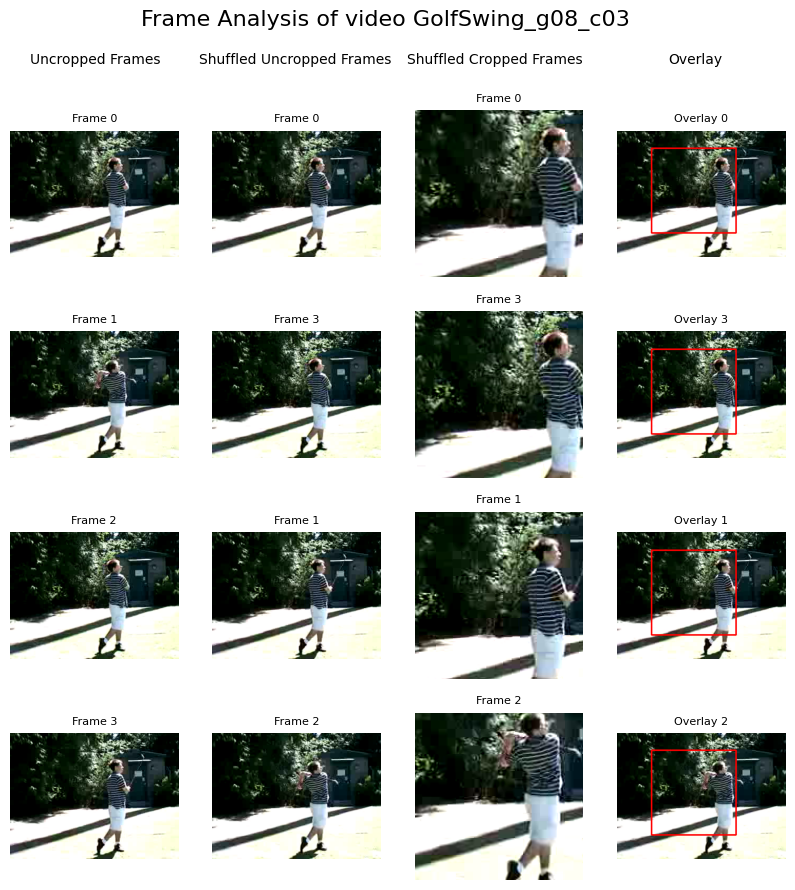

In [194]:
def test_temporal_four(temporal_four, n):
    input_frames, frame_order_label, action_label, video_name, frames_canonical_order, shuffled_uncropped_frames, input_frames_coordinates = temporal_four[2]

    visualize_frames(input_frames, shuffled_uncropped_frames, frames_canonical_order, video_name, input_frames_coordinates)
    #visualize_optical_flow(flows, indices) # TODO add method to get_flows&indices

def visualize_frames(input_frames, shuffled_uncropped_frames, frames_canonical_order, video_name, input_frames_coordinates):
    # Reorder the select_frames to their "original" order based on frames_canonical_order
    ordered_uncropped_frames = shuffled_uncropped_frames[frames_canonical_order]

    # Create a figure and a grid of subplots with an extra row for the column titles
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, (cropped_frame, ordered_uncropped_frame, shuffled_uncropped_frame) in enumerate(zip(input_frames, ordered_uncropped_frames, shuffled_uncropped_frames)):
        cropped_frame = cropped_frame.numpy()

        axs[i, 0].imshow(ordered_uncropped_frame)
        axs[i, 0].set_title(f'Frame {i}', fontsize=8)
        axs[i, 0].axis('off')

        axs[i, 1].imshow(shuffled_uncropped_frame)
        axs[i, 1].set_title(f'Frame {frames_canonical_order[i]}', fontsize=8)
        axs[i, 1].axis('off')

        axs[i, 2].imshow(cropped_frame)
        axs[i, 2].set_title(f'Frame {frames_canonical_order[i]}', fontsize=8)
        axs[i, 2].axis('off')

        # New column: overlay cropped frame on uncropped frame
        overlay = shuffled_uncropped_frame.copy()
        startx, starty = input_frames_coordinates[0][1], input_frames_coordinates[0][0]
        patch_size = cropped_frame.shape[0]
        endx, endy = startx + patch_size, starty + patch_size
        cv2.rectangle(overlay, (startx, starty), (endx, endy), (255, 0, 0), 2)  # Draw red rectangle
        axs[i, 3].imshow(overlay)
        axs[i, 3].set_title(f'Overlay {frames_canonical_order[i]}', fontsize=8)
        axs[i, 3].axis('off')

    # Set a common title for the entire plot
    fig.suptitle(f'Frame Analysis of video {video_name}', fontsize=16)

    # Define the titles for each column
    column_titles = ['Uncropped Frames', 'Shuffled Uncropped Frames', 'Shuffled Cropped Frames', 'Overlay']

    # Set the column titles manually using the text function
    fig.text(0.21, 0.93, column_titles[0], ha='center', va='center', fontsize=10)
    fig.text(0.41, 0.93, column_titles[1], ha='center', va='center', fontsize=10)
    fig.text(0.61, 0.93, column_titles[2], ha='center', va='center', fontsize=10)
    fig.text(0.81, 0.93, column_titles[3], ha='center', va='center', fontsize=10)

    plt.show()

def visualize_optical_flow(flows, indices):
    # Reorder the flows based on indices
    flows = [flows[i] for i in indices[:-1]]

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

    # Visualize the optical flow
    for i in range(3):
        flow = flows[i]
        flow = flow.numpy()
        hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
        hsv[...,1] = 255

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        # New code
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        mag = np.uint8(mag)
        hsv[...,2] = mag
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        im = axs[i].imshow(rgb)
        axs[i].set_title(f'Optical flow from frame {i} to its next', fontsize=10)
        axs[i].axis('off')

        # Add a color bar
        fig.colorbar(im, ax=axs[i], orientation='vertical')
        
    # Display the figure with the subplots
    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_load = 6
video_dataset = PreparedDataset(videos, trainval='train')
temporal_four = PreprocessedTemporalFourData(video_dataset, trainval='train')
test_temporal_four(temporal_four, amount_of_videos_to_load)
torch.save(temporal_four, 'dataset_train.pth')